In [1]:
import numpy as np
import pandas as pd
import h5py
from atlasify import AtlasStyle
import matplotlib.pyplot as plt
import sys

In [34]:
# H5/Pandas Utils

def get_fields(h5_path, group, variables, num=None):
    """
    Load field data from h5 file
    """     
    with h5py.File(h5_path) as f:
        num = int(num) if num is not None else None
        
        return f[group].fields(variables)[:num]
    
    
def get_jet_df(h5_path, variables, group="jets", num_jets=None):
    """
    Load jet data into pandas dataframe
    """
    data = get_fields(h5_path, group, variables, num_jets)
    
    return pd.DataFrame(data)


def get_track_df(h5_path:str, variables: list, group="tracks_from_jet",jet_variables=None, num=None):
    """
    Load flattened track data into pandas dataframe
    """

    with h5py.File(h5_path) as f:
        num = int(num) if num is not None else None
        track_dataset = f[group]
        valid_tracks_bool = f[group]["valid"]
        n_tracks_in_jet = np.sum(valid_tracks_bool,axis=1)
        valid_tracks = track_dataset[valid_tracks_bool]
        tracks_df = pd.DataFrame(valid_tracks[variables])
    
    # load jet variables in track df
    if jet_variables:
        jet_data=get_fields(h5_path, "jets", jet_variables, num=None)
        jet_in_track_df = pd.DataFrame({"pt_btagJes":np.repeat(np.array(jet_data),n_tracks_in_jet)})
        tracks_df = tracks_df.join(jet_in_track_df.astype(int))
    
    return tracks_df


def get_n_tracks(h5_path, num=None):
    """
    Number of tracks in each jet
    """
    with h5py.File(h5_path) as f:
        num = int(num) if num is not None else None
        track_dataset = f[group]
        valid_tracks_bool = f[group]["valid"]
        
        return np.sum(valid_tracks_bool,axis=1)

    
def return_column_names(h5_path:str, group:str) -> tuple: 
    """
    Return colulm headings
    """
    with h5py.File(h5_path) as f:
        data=f[group]
        column_names = data.dtype.names
        
        return column_names
    
def filter_tracks(track_df):
    """
    From track dataframe, filter displaced tracks
    """
    mask = track_df["truthVertexIndex"] > 0
    
    return track_df[mask]


def standardise_column_names(track_df,jet_df=None):
    """
    Standardise column names for downstream functions
    """
    return track_df.rename(columns={"VertexIndex":"GN2VertexIndex"})


def groupby_variables(node_df,variables:list):
    """
    Group the nodes trueVertex in for each jet(TODO: change from pt_btagJes to jet id)
    """
    grouped_obj = node_df.groupby(variables)
    
    return grouped_obj

def get_single_jet(h5_path, jet_idx, sort_vert_idx = True):
    """
    Load tracks from a jet and return information for event-disp 
    """
    
    with h5py.File(h5_path,"r") as f:
        
        tracks_from_jet = f["tracks_from_jet"][jet_idx]

        if sort_vert_idx == False:
            return tracks_from_jet
        
        # return predict,true labels sorted by truthVertexIndex (to group for adj mtrx)  
        
        pred_origin = np.array([ asn_pred_idx(single_trk, class_dict, pcut=0.5) for single_trk in tracks_from_jet])
        truth_origin = tracks_from_jet["truthOriginLabel"]
        pred_vert_idx = tracks_from_jet["VertexIndex"]
        truth_vert_idx = tracks_from_jet["truthVertexIndex"]
        vsi_vert_idx = tracks_from_jet["VSIVertexIndex"]
        
        sorted_idx = np.argsort(truth_vert_idx)
        
        pred_origin = pred_origin[sorted_idx]
        truth_origin = truth_origin[sorted_idx] 
        pred_vert_idx = pred_vert_idx[sorted_idx]
        truth_vert_idx = truth_vert_idx[sorted_idx]
        vsi_vert_idx = vsi_vert_idx[sorted_idx] 
        
        # calculate adjacency matrices
        N = len(truth_origin)
        adj = get_adj(truth_vert_idx)
        adj_gnn = get_adj(pred_vert_idx)
        adj_vsi = get_adj(vsi_vert_idx)
    
        truth = {}
        truth['adj'] = adj
        truth['origin'] = truth_origin

        pred = {}
        pred['adj_gnn'] = adj_gnn
        pred['adj_vsi'] = adj_vsi
        pred['origin'] = pred_origin
        
        return N, truth, pred




In [35]:
# Event display tools 
jet_class_dict = {
    1: {"name":'GN2_p_disp'},
    0: {"name":'GN2_p_prompt'}
}

class_dict = {
    0 : {"label": 0, "weight": 1.0,    'name': 'Pileup'        , 'color': 'gray'},
    1 : {'label': 1, 'weight': 1.0,   'name': 'Fake'          , 'color': 'tomato'},
    2 : {'label': 2, 'weight': 1.0,   'name': 'Primary'       , 'color': 'cornflowerblue'},
    3 : {'label': 3, 'weight': 1.0,   'name': 'Displaced'     , 'color': 'seagreen'},
}
    
    
def get_adj(array):
    u = array
    N = u.shape[0]
    tile = np.tile(u,(N,1))
    adj = ((tile-tile.T == 0) & (tile != -2)).astype(int)
    return -adj

    
def asn_pred_idx(struc_arr, class_dict, pcut=0.5):
    """
    From an element(of composite datatype) with probablity output for all classes, return label
    for predicted probality
    """
    
    # get class names
    lbl_name = {class_label:info_dict["name"]  for class_label, info_dict in class_dict.items()}
    class_name = list(lbl_name.values())
    
    # max prob label: isn't an arr so iterating the tuple like composite dtype element
    struc_probs = struc_arr[class_name]
    max_index = max(range(len(struc_probs)), key=lambda i: struc_probs[i])
    max_field = struc_probs.dtype.names[max_index]
    name_lbl = {value:key for key,value in lbl_name.items()}

    return name_lbl[max_field]





In [39]:
# Vertex Plot Utils

# NUM NODES
def get_num_nodes(node_df,n,models):
    """
    Number of nodes for models and MonteCarlo {model_name: num_nodes, true: num_nodes }
    """
    # output variable
    output={}
        
    # gorup into each true node
    true_nodes = node_df.groupby(["pt_btagJes","truthVertexIndex"])
    
    # TEMP filter for only using tracks which VSI has assigned verticis to
    true_nodes = true_nodes.filter(lambda x: x["VSIVertexIndex"].value_counts().idxmax() >= 0).groupby(["pt_btagJes","truthVertexIndex"])
    
    # filter groups into nodes per trueVertex, predictVertex with > n tracks and write outout for num nodes
    true_nodes = true_nodes.filter(lambda x: len(x) > n).groupby(["pt_btagJes","truthVertexIndex"])
    num_true_nodes = true_nodes.filter(lambda x: len(x) > n).groupby(["pt_btagJes","truthVertexIndex"]).ngroups
    output["MC"] = num_true_nodes
    
    for model_name in models:
        
        predict_nodes = true_nodes.apply(pd.DataFrame).groupby(["pt_btagJes",model_name+"VertexIndex"])
        # require that predicted vertex is a secondary vertex --> index > 0 
        predict_nodes = predict_nodes.filter(lambda x: x[model_name+"VertexIndex"].value_counts().idxmax() >= 0)
        num_predict_nodes = predict_nodes.groupby(["pt_btagJes",model_name+"VertexIndex"]).ngroups
        output[model_name] = num_predict_nodes
                                                      
    return output 


# EFFICIENCY

def get_efficiency(node_df,n,models=["GN2","VSI"]):
    
    # Init
    predict_vertex={}
    effi_output =np.array([])
    eff_arr=np.array([])
    eff_sum=0
    output={}
    for model_name in models:
        output[model_name]={}
    
    # Efficiency defination for a single vertex
    def get_vert_eff(true_vertex_df, predict_vertex_grp):
        
        index_true = np.array(true_vertex_df.index)
        len_index_true = len(index_true)
        #print("trueVertTrkInx:", index_true)
        
        # Match to a predict vertex: 
        
        # get the key of predict_vertex_grp based on track indices of true node
        predict_keys=[] 
    
        for i in index_true:
            predict_key = next((predict_key for predict_key, trk_indices in predict_vertex_grp.groups.items() if i in trk_indices), None)
            if predict_key is not None and predict_key not in predict_keys:
                predict_keys.append(predict_key)
       
        # conditions for being matched as vertex
        eff_vert=np.array([])
        for predict_key in predict_keys:
            
            # get all tracks for predict vertex whose track id matches to true_vertex_df
            index_predict = np.array(predict_vertex_grp.groups[predict_key])
            
            # defination
            intersect_count = np.intersect1d(index_predict,index_true).size
            efficiency = intersect_count/len_index_true
            
            # >=2 tracks GNN
            if len(index_predict) <2:
                efficiency  = 0
                
            # >=2 tracks VSI 
            #print(predict_key)
            if predict_key == -2.0:
                efficiency = 0
                
            # >= 50% track matched
            if intersect_count/len(index_predict) < 0.5: 
                efficiency = 0
            
            #print("predictVertTrkInx:", index_predict, efficiency)
            eff_vert=np.append(eff_vert,efficiency)
            
        
        #print("VertEff:",np.max(eff_vert))

        return np.max(eff_vert) 
  
    # jet groups 
    jet_grp = node_df.groupby(["pt_btagJes"])
    
    # total true vertex with > n tracks
    total_true_vertex = node_df.groupby(["pt_btagJes","truthVertexIndex"]).filter(lambda x: len(x) > n).groupby(["pt_btagJes","truthVertexIndex"]) 
    total_true_vertex=len(total_true_vertex)
    for model_name in models:
        for jet_key, jet_df in jet_grp:
            true_vertices = jet_df.groupby(["truthVertexIndex"])
            # Efficiency for n> tracks in a vertex
            true_vertices = true_vertices.filter(lambda x: len(x) > n).groupby(["truthVertexIndex"])
            predict_vertices = jet_df.groupby([model_name+"VertexIndex"])
        
            for truth_key, true_vertex_df in true_vertices:
                efficiency_output =  get_vert_eff(true_vertex_df,predict_vertices)
                eff_arr =np.append(eff_arr,efficiency_output)  
                
        output[model_name]["Mean"]= eff_arr.mean()
        output[model_name]["Varience"]= np.var(eff_arr)
        output[model_name]["Count"]= None
            
    
    return output 

# PURITY
def get_purity(node_df,n,models=["GN2","VSI"]):
    
    # Init
    purity_output =np.array([])
    putity_sum = 0
    purity_arr=np.array([])
    output={}
    for model_name in models:
        output[model_name]={}
    
    
    # Purity defination for a single vertex
    def get_vert_purity(predict_vertex_df, true_vertex_grp):
        
        idx_predict = np.array(predict_vertex_df.index)
        len_idx_predict = len(idx_predict)
        #print("predictVertTrkInx:", idx_predict)
        
        # Match to a true vertex: 
        
        # get the key of true_vertex_grp based on track indices of true node
        true_keys=[] 
    
        for i in idx_predict:
            true_key = next((true_key for true_key, trk_indices in true_vertex_grp.groups.items() if i in trk_indices), None)
            if true_key is not None and true_key not in true_keys:
                true_keys.append(true_key)
       

        pure_vert=np.array([])
        for true_key in true_keys:
            
            # get all tracks for true vertex whose track id matches to predict_vertex_df
            idx_true = np.array(true_vertex_grp.groups[true_key])
            
            # defination
            intersect_count = np.intersect1d(idx_true,idx_predict).size
            purity = intersect_count/len_idx_predict

            #print("trueVertTrkInx:", idx_true, purity)
            pure_vert=np.append(pure_vert,purity)
            
        
        #print("VertPurity:",np.max(pure_vert))
        #print("")

        return np.max(pure_vert) 
  
    # jet groups 
    jet_grp = node_df.groupby(["pt_btagJes"])
    
    
    for model_name in models:
        
        for jet_key, jet_df in jet_grp:
            
            predict_vertices = jet_df.groupby([model_name+"VertexIndex"])
            
            # filters out 1 track vertices for GN2 and VSI
            predict_vertices = predict_vertices.filter(lambda x: len(x) >= n).groupby([model_name+"VertexIndex"])
            predict_vertices = predict_vertices.filter(lambda x: x.name != -2).groupby([model_name+"VertexIndex"])
            
            # filters out predicted primary vertices! 
            predict_vertices = predict_vertices.filter(lambda x: x.name != -0).groupby([model_name+"VertexIndex"])
            
            true_vertices = jet_df.groupby(["truthVertexIndex"])
        
            for predict_key, predict_vertex_df in predict_vertices:
                
                purity_output =  get_vert_purity(predict_vertex_df, true_vertices)
                purity_arr = np.append(purity_arr,purity_output)         
        
        output[model_name]["Mean"]= purity_arr.mean()
        output[model_name]["Varience"] = np.var(purity_arr)
        output[model_name]["Count"] = None
            
    
    return output 
    




In [45]:
# Ploting

# plot style
atlas_style = AtlasStyle(
    atlas='Simulation Internal',
    offset=7,
    indent=7,
    font_size=13,
    sub_font_size=10,
    enlarge=1
)

# step function 
def y_on_var_bins(node_df, y, variable:str, variable_range:list ,n_bins ,min_track, models=["GN2","VSI"]):
    """
    Returns y_values for bins of given variable and range [{model:y[x_bin]},x_bins]
    """
    # group input df by a range of variable
    variable_bins = np.linspace(variable_range[0],variable_range[1], n_bins)
    grouped_by_bins = node_df.groupby(pd.cut(node_df[variable],variable_bins))
    
    # output
    output={}
    for model_name in models:
        output[model_name]={}
        output[model_name]["Mean"]=[]
        output[model_name]["Varience"]=[]
        output[model_name]["Count"]=[]
        
    
    # finding y val for each bins
    for x_bin_range, x_input_df in grouped_by_bins:
        
        # call y on x_input_df
        if y == "Purity":
            func = get_purity(x_input_df,min_track,models)
            
            for model_name in models:
                output[model_name]["Mean"].append(func[model_name]["Mean"])
                output[model_name]["Varience"].append(func[model_name]["Varience"])
            output[model_name]["Count"]=None
            
        elif y == "NumNodes":
            func = get_num_nodes(x_input_df,min_track,models)
                
            for model_name in models:
                output[model_name]["Count"].append(func[model_name]["Count"])
            
        elif y == "Efficiency":
            func = get_efficiency(x_input_df,min_track,models)
            
            for model_name in models:
                output[model_name]["Mean"].append(func[model_name]["Mean"])
                output[model_name]["Varience"].append(func[model_name]["Varience"])
            output[model_name]["Count"]=None   
            
       
        print(output)
            
    return [output,variable_bins]    
        
# step histogram
def plot_step_hist(model_val_dict,x_bins,x_label,y_label,models,y_err=None):
    
    for model_name in models:
        """
        if model_val_dict[model_name]["Count"] is not None | len(model_val_dict[model_name]["Count"] !=0):
            plt.step(x_bins[:-1],model_val_dict[model_name]["Count"],where="post", label = model_name)
        else:
        """
        yerr=np.array(model_val_dict[model_name]["Varience"])
        yval=np.array(model_val_dict[model_name]["Mean"])
        plt.step(x_bins[:-1],yval,where="post", label = model_name)
        #plt.fill_between(x_bins[:-1], yval-yerr, yval+yerr, step='post', color='k', alpha=0.15)
        
    # styling
    atlas_style.apply()
    if model_val_dict["GN2"]["Count"] is not None:
        plt.ylim([0,1])
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(f"Step Function")
    plt.show()
    return

# adj mtrx plot
def plt_adj_mtrx(adj_mtrx, origins, title):
    
    # plot the adjacency matrix
    plt.imshow(adj_mtrx, cmap='gray')

    # plot track origins
    class_colors = {k: v['color'] for k, v in class_dict.items()}
    #TODO: Change N 
    for i in range(40):
        plt.scatter([i], [i], c=class_colors[origins[i]], zorder=100, linewidth=0.5)
    
    plt.title(title, fontweight='medium', fontsize=10)
    plt.ylabel('$n_{track}$', fontsize=12)
    plt.xlabel('$n_{track}$', fontsize=12)
    plt.show()
    #plt.savefig("event_disp.png") 
    
    
    return
    
    
    

{'GN2': {'Mean': [0.489220405726773], 'Varience': [0.14256379517913176], 'Count': []}, 'VSI': {'Mean': [0.4215162514989979], 'Varience': [0.1565391220807137], 'Count': None}}
{'GN2': {'Mean': [0.489220405726773, 0.49437614786071105], 'Varience': [0.14256379517913176, 0.14268854966909275], 'Count': []}, 'VSI': {'Mean': [0.4215162514989979, 0.4256883238892181], 'Varience': [0.1565391220807137, 0.15807523738739698], 'Count': None}}
{'GN2': {'Mean': [0.489220405726773, 0.49437614786071105, 0.5324157973601189], 'Varience': [0.14256379517913176, 0.14268854966909275, 0.15409821103584198], 'Count': []}, 'VSI': {'Mean': [0.4215162514989979, 0.4256883238892181, 0.45659857120625563], 'Varience': [0.1565391220807137, 0.15807523738739698, 0.17110906701253256], 'Count': None}}
{'GN2': {'Mean': [0.489220405726773, 0.49437614786071105, 0.5324157973601189, 0.5667943189259138], 'Varience': [0.14256379517913176, 0.14268854966909275, 0.15409821103584198, 0.16242214590349402], 'Count': []}, 'VSI': {'Mean':

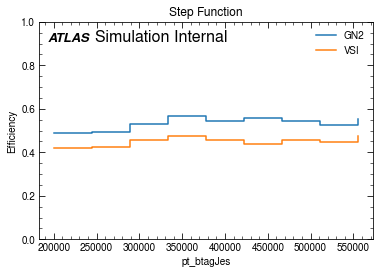

In [48]:
# Testing

if __name__ == '__main__':
    h5_path = "/home/ppokhare/projects/ctb-stelzer/ppokhare/salt/salt/logs/GN2_20230502-T194918/lightning_logs/version_0/ckpts/epoch=029-val_loss=0.10556__test_ej_PFlow.h5"    
  
    # load track dataframe
    group = "tracks_from_jet"
    variables = ["VSIVertexIndex","VertexIndex","truthVertexIndex"]
    track_df=get_track_df(h5_path,variables,group,jet_variables=["pt_btagJes"])
  
    # standard names
    track_df = standardise_column_names(track_df)
    
    # inlcude trcks with truthSV only! 
    track_df = filter_tracks(track_df)
    
    # testing efficiency
    #effi = get_efficiency_v_3(track_df,2,models=["VSI"])


    # get efficiency
    effi_vs_pt = y_on_var_bins(track_df,"Efficiency","pt_btagJes",[200000,600000],10,3, models=["GN2","VSI"])
    
    # plot    
    plot_step_hist(effi_vs_pt[0],effi_vs_pt[1],"pt_btagJes","Efficiency",models=["GN2","VSI"])
  
    
    
    """
    # plot adj matrx of vertex
    #GN2
    jet_idx = 20659
    adj_mtrx = get_single_jet(h5_path, jet_idx)[2]["adj_gnn"]
    origins = get_single_jet(h5_path, jet_idx)[2]["origin"]
    plt_adj_mtrx(adj_mtrx,origins,"GN2")
    #VSI (with truth origin)
    origins = get_single_jet(h5_path, jet_idx)[1]["origin"]
    adj_mtrx = get_single_jet(h5_path, jet_idx)[2]["adj_vsi"]
    plt_adj_mtrx(adj_mtrx,origins,"VSI")
    #truth
    origins = get_single_jet(h5_path, jet_idx)[1]["origin"]
    adj_mtrx = get_single_jet(h5_path, jet_idx)[1]["adj"]
    plt_adj_mtrx(adj_mtrx,origins,"Truth Labels")
    """
    
   



    
    
    
  
